# Artificial Source Objects

To generate synthetic images, **ArtPop** "observes" [Source](../api/artpop.source.Source.rst) objects. In essence, ``Source`` objects are containers that hold the ``xy`` pixel positions and stellar ``mags`` of the artificial stellar population.  As we showed in the [Building Stellar Populations](pops.ipynb) and [Sampling Spatial Distributions](spatial.ipynb) tutorials, **ArtPop** has the capability to generate these parameters, but you can generate them in _any_ way you want (i.e., independently from **ArtPop**). You just need to make sure to create ``xy`` and ``mags`` in the correct format to initialize the [Source](../api/artpop.source.Source.rst).

In [1]:
# Third-party imports 
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u   

# Project import
import artpop

# artpop's matplotlib style
plt.style.use(artpop.mpl_style)

# use this random state for reproducibility
rng = np.random.RandomState(9)

## Building a Source Object

In this first example, we will show you how to build a ``Source`` object from scratch. We'll assume a uniform distribution of stars at fixed surface brightness. We start by creating a simple stellar population (SSP), which we will use to calculate the mean stellar magnitude of the population:

In [2]:
# Here we use total_mass instead of num_stars, 
# one of which is required. We use a relatively 
# large mass to ensure we fully sample the imf.
ssp = artpop.SSP(
    log_age = 9,          # log of age in years
    feh = -1,             # metallicity [Fe/H]
    phot_system = 'LSST', # photometric system(s)
    total_mass = 1e6,     # total mass (in solar masses)
    imf = 'kroupa',       # default imf
    random_state = rng,   # random state for reproducibility
)

Next we use the [constant_sb_stars_per_pix](../api/artpop.stars.constant_sb_stars_per_pix.rst) function to calculate the number of stars this population would have for a given surface brightness and distance (let's put the population at 10 Mpc):

In [3]:
distance = 10 * u.Mpc

num_stars_per_pix = artpop.constant_sb_stars_per_pix(
    sb = 24,                           # surface brightness
    mean_mag = ssp.mean_mag('LSST_i'), # mean stellar magnitude
    distance = distance,               # distance to system
    pixel_scale = 0.2                  # pixel scale in arcsec/pixel
)

print(f'number of stars per pixel = {num_stars_per_pix:.2f}')

number of stars per pixel = 495.20


Let's say we intend to create an artificial image that is 101 pixels on a side. Then we can calculate the number of pixels, and hence number of stars, in our image.

In [4]:
xy_dim = (101, 101)
num_stars = int(np.multiply(*xy_dim) * num_stars_per_pix)
print(f'number of stars = {num_stars:.0e}')

number of stars = 5e+06


Putting the pieces together, we sample ``num_stars`` stellar magnitudes and positions to build our ``Source`` object:

In [5]:
# build SSP with num_stars stars
ssp = artpop.SSP(
    log_age = 9,           # log of age in years
    feh = -1,              # metallicity [Fe/H]
    phot_system = 'LSST',  # photometric system(s)
    num_stars = num_stars, # number of stars
    imf = 'kroupa',        # default imf
    distance = distance,   # distance to system
    random_state = rng,    # random state for reproducibility
)

# sample num_stars positions in a uniform grid
xy = np.vstack([rng.uniform(0, xy_dim[0], num_stars), 
                rng.uniform(0, xy_dim[1], num_stars)]).T

# create the artificial source
src = artpop.Source(xy, ssp.mag_table, xy_dim)

Note ``ssp`` has an attribute called ``mag_table``, which is an ``astropy`` table with stellar magnitudes in the given photometric system(s), which is passed as an argument to ``Source`` and stored as the ``mags`` attribute:

In [6]:
# here are the first 10 rows of the table
# each row corresponds to a single star
src.mags[:10]

LSST_u,LSST_g,LSST_r,LSST_i,LSST_z,LSST_y
float64,float64,float64,float64,float64,float64
41.245967896527496,39.116345309541806,38.11552520117903,37.712869735097286,37.525903151463034,37.40832764371542
40.33444161905277,38.40068038450674,37.55813560953756,37.230937200738744,37.08218116182685,36.98435328554789
43.72543051114125,41.27549045677455,40.010378388649414,39.46707345770921,39.20860887714477,39.05429110386038
43.41653204090416,40.992648313353584,39.74509730778611,39.21259535384653,38.959266823574644,38.80760839684088
37.46196506006562,36.39862954514639,35.95996541220282,35.80744429527467,35.76143650840421,35.737744640632535
46.712159012602555,43.72614816136536,42.241532890373904,41.458356149256524,41.085694349390124,40.8901735681556
38.422280850764025,37.06018122315692,36.50302784832606,36.297802263938614,36.21824078478676,36.1690618538193
45.031955639425206,42.418295026493006,41.059084281300514,40.442418195050756,40.14772596126622,39.97726838207657
45.03107877586019,42.41754777172925,41.058402983327376,40.441800323620654,40.147139835675176,39.97669793901019


The ``src`` object contains all the information we need to simulate an observation of the artificial source, which is described in the [Making Artificial Images](../tutorials/artimages.ipynb) tutorial. 


Here's a look at the positions and $i$-band magnitudes of a random subset of the stars in ``src``:

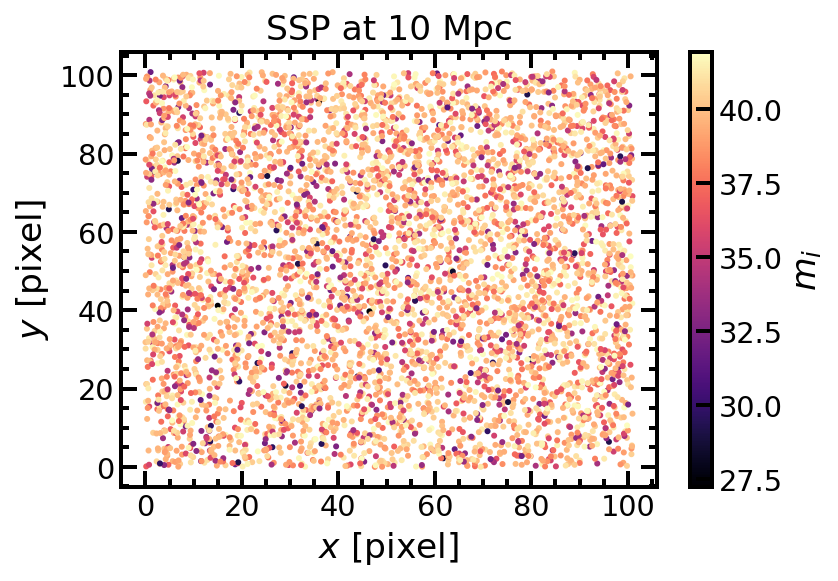

In [7]:
idx = rng.choice(np.arange(src.num_stars), 5000, replace=False)
plt.scatter(src.x[idx], src.y[idx], s=4, 
            c=src.mags['LSST_i'][idx], cmap='magma')

cbar = plt.colorbar()
cbar.ax.set_ylabel('$m_i$')
plt.xlabel('$x$ [pixel]')
plt.ylabel('$y$ [pixel]')
plt.title(f'SSP at {distance:.0f}')
plt.minorticks_on();

As a sanity check, we can calculate the surface brightness of the population:

In [8]:
total_flux = (10**(-0.4 * src.mags['LSST_i'])).sum()
area = (101 * 0.2)**2
sb = -2.5 * np.log10(total_flux / area)
print(f'SB = {sb:.2f} mag / arcsec^2')

SB = 24.00 mag / arcsec^2


## Helper SSP Source Objects

For convenience, **ArtPop** provides objects for generating SSP + spatial distribution combinations. Here we generate an SSP with a uniform spatial distribution, similar to above, using the [UniformSSP](../api/artpop.source.UniformSSP.rst) helper SSP class:

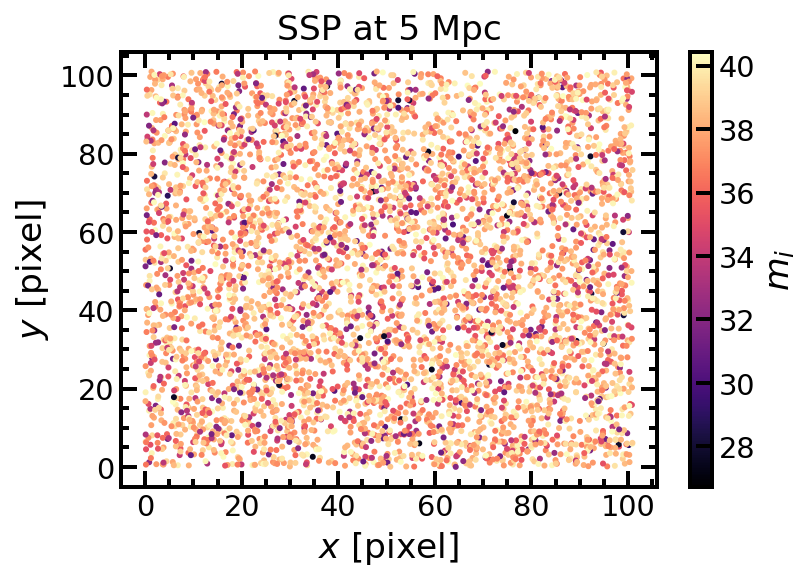

In [9]:
# let's put the population at 5 Mpc
distance = 5 * u.Mpc

# create ssp distributed uniformly in space
src_uniform = artpop.UniformSSP(
    log_age = 9,          # log of age in years
    feh = -1,             # metallicity [Fe/H]
    phot_system = 'LSST', # photometric system(s) 
    distance = distance,  # distance to system 
    xy_dim = 101,         # image dimension (101, 101)
    sb = 24,              # surface brightness (SB)
    sb_bandpass='LSST_i', # bandpass to calculate the SB
    random_state = rng,   # random state for reproducibility    
)

# plot positions with symbols colored by i-band mags
idx = rng.choice(np.arange(src_uniform.num_stars), 5000, replace=False)
plt.scatter(src_uniform.x[idx], src_uniform.y[idx], s=4, 
            c=src_uniform.mags['LSST_i'][idx], cmap='magma')

cbar = plt.colorbar()
cbar.ax.set_ylabel('$m_i$')
plt.xlabel('$x$ [pixel]')
plt.ylabel('$y$ [pixel]')
plt.title(f'SSP at {distance:.0f}')
plt.minorticks_on();

## Composite Sources

Similar to [creating composite stellar populations](pops.ipynb#Composite-Stellar-Populations), composite ``Source`` objects are created intuitively using the ``+`` operator. Here we'll use [PlummerSSP](../api/artpop.source.PlummerSSP.rst) to create an SSP with a Plummer spatial distribution and add it to the uniformly distributed population we created above:

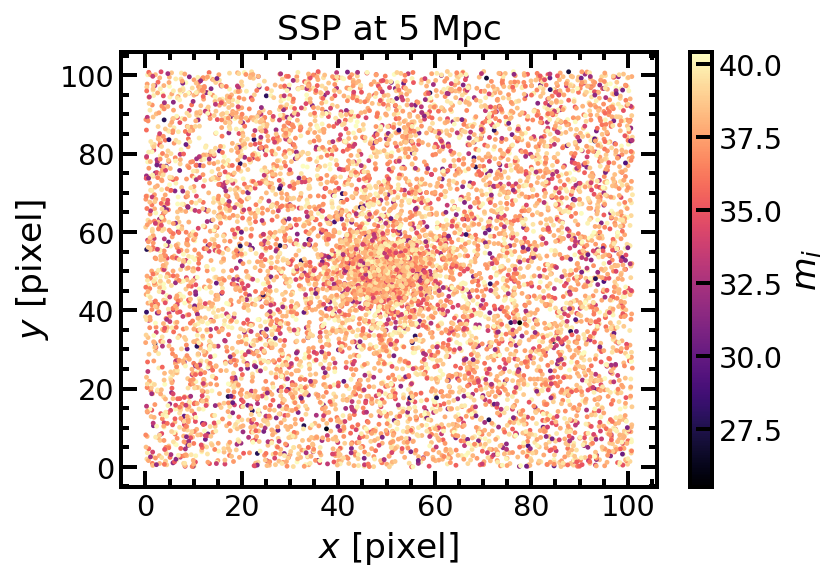

In [10]:
# create ssp distributed uniformly in space
src_plummer = artpop.PlummerSSP(
    log_age = 10.1,           # log of age in years
    feh = -1.5,               # metallicity [Fe/H]
    scale_radius = 20 * u.pc, # effective radius
    num_stars = 5e5,          # number of stars
    phot_system = 'LSST',     # photometric system(s) 
    distance = distance,      # distance to system 
    xy_dim = 101,             # image dimension (101, 101)
    random_state = rng,       # random state for reproducibility
)

# add sources together
composite_src = src_uniform + src_plummer

# plot positions with symbols colored by i-band mags
idx = rng.choice(np.arange(composite_src.num_stars), int(1e4), replace=False)
plt.scatter(composite_src.x[idx], composite_src.y[idx], s=2, 
            c=composite_src.mags['LSST_i'][idx], cmap='magma')

cbar = plt.colorbar()
cbar.ax.set_ylabel('$m_i$')
plt.xlabel('$x$ [pixel]')
plt.ylabel('$y$ [pixel]')
plt.title(f'SSP at {distance:.0f}')
plt.minorticks_on();